In [110]:
# # MNIST Data
# import numpy as np
# from tensorflow.examples.tutorials.mnist import input_data
# import impl.layer as l

# # Dataset preparation and pre-processing
# mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

# X_train, y_train = mnist.train.images, mnist.train.labels
# X_val, y_val = mnist.validation.images, mnist.validation.labels
# X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype, y_train.shape, y_val.shape, y_test.shape

In [111]:
import pandas as pd # to read CSV files (Comma Separated Values)

train_x = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/train.x.csv')
train_x.head()

,Id,att1,att2,att3,att4,att5,att6,att7,att8,att9,...,att18,att19,att20,att21,att22,att23,att24,att25,att26,msd_track_id
0,1,41.08,6.579,4.307,3.421,3.192,2.076,2.179,2.052,1.794,...,1.3470,-0.2463,-1.5470,0.17920,-1.1530,-0.7370,0.40750,-0.67190,-0.05147,TRPLTEM128F92E1389
1,2,60.80,5.973,4.344,3.261,2.835,2.725,2.446,1.884,1.962,...,-0.3316,0.3519,-1.4760,0.52700,-2.1960,1.5990,-1.39000,0.22560,-0.72080,TRJWMBQ128F424155E
2,3,51.47,4.971,4.316,2.916,3.112,2.290,2.053,1.934,1.878,...,-0.2803,-0.1603,-0.1355,1.03500,0.2370,1.4890,0.02959,-0.13670,0.10820,TRRZWMO12903CCFCC2
3,4,41.28,6.610,4.411,2.602,2.822,2.126,1.984,1.973,1.945,...,-1.6930,1.0040,-0.3953,0.26710,-1.0450,0.4974,0.03724,1.04500,-0.20000,TRBZRUT12903CE6C04
4,5,54.17,8.945,4.685,4.208,3.154,3.527,2.733,2.202,2.686,...,2.4690,-0.5449,-0.5622,-0.08968,-0.9823,-0.2445,-1.65800,-0.04825,-0.70950,TRLUJQF128F42AF5BF


In [112]:
train_y = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/train.y.csv')
train_y.head()

,Id,class_label
0,1,International
1,2,Vocal
2,3,Latin
3,4,Blues
4,5,Vocal


In [113]:
test_x = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/test.x.csv')
test_x.head()

,Id,att1,att2,att3,att4,att5,att6,att7,att8,att9,...,att17,att18,att19,att20,att21,att22,att23,att24,att25,att26
0,1,38.22,8.076,6.935,4.696,3.856,3.465,2.922,2.568,2.070,...,3.988,0.4957,0.1836,-2.2210,0.6453,-0.2923,1.2000,-0.09179,0.4674,0.2158
1,2,36.42,6.131,5.364,4.292,3.968,2.937,2.872,2.142,2.050,...,7.098,1.2290,0.5971,-1.0670,0.9569,-1.8240,2.3130,-0.80890,0.5612,-0.6225
2,3,70.01,5.496,4.698,3.699,3.258,2.293,2.680,2.226,2.034,...,4.449,0.4773,1.6370,-1.0690,2.4160,-0.6299,1.4190,-0.81960,0.9151,-0.5948
3,4,40.64,7.281,6.702,4.043,3.729,3.043,2.644,2.366,1.940,...,2.785,1.9000,-1.1370,1.2750,1.7920,-2.1250,1.6090,-0.83230,-0.1998,-0.1218
4,5,38.85,7.118,5.703,4.825,4.088,3.823,3.254,2.551,2.193,...,4.536,2.1470,1.0200,-0.2656,2.8050,0.2762,0.2504,1.04900,0.3447,-0.7689


In [114]:
test_y_sample = pd.read_csv(filepath_or_buffer='data/kaggle-music-genre/submission-random.csv')
test_y_sample.head()

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,1,0.0964,0.0884,0.0121,0.1004,0.0137,0.1214,0.0883,0.0765,0.0332,0.0445,0.1193,0.1019,0.1038
1,2,0.0121,0.0804,0.0376,0.0289,0.1310,0.0684,0.1044,0.0118,0.1562,0.0585,0.1633,0.1400,0.0073
2,3,0.1291,0.0985,0.0691,0.0356,0.0788,0.0529,0.1185,0.1057,0.1041,0.0075,0.0481,0.1283,0.0238
3,4,0.0453,0.1234,0.0931,0.0126,0.1224,0.0627,0.0269,0.0764,0.0812,0.1337,0.0357,0.0937,0.0930
4,5,0.0600,0.0915,0.0667,0.0947,0.0509,0.0335,0.1251,0.0202,0.1012,0.0365,0.1310,0.0898,0.0991


In [115]:
test_y_sample[:0]

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal


In [116]:
import numpy as np

train_X = np.array(train_x)
train_Y = np.array(train_y[:]['class_label'])
test_X = np.array(test_x)

# Getting rid of the first and the last column: Id and msd_track_id
X_train_val = np.array(train_X[:, 1:-1], dtype=float)
X_test = np.array(test_X[:, 1:], dtype=float)

train_Y.shape

(13000,)

In [117]:
# from collections import Counter
# # Count the freq of words in the text/collection of words
# word_counts = Counter(text)
# # Having counted the frequency of the words in collection, sort them from most to least/top to bottom/descendng
# sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
# # first enumerating for vocab to int
# vocab_to_int = {words: ii for ii, words in enumerate(sorted_vocab)}
# # into_to_vocab after enumerating through the sorted vocab
# int_to_vocab = {ii: words for words, ii in vocab_to_int.items()}

In [282]:
from collections import Counter

# Count the freq of the keys in the training labels
counted_labels = Counter(train_Y)
labels_keys = counted_labels.keys()
labels_keys

dict_keys(['Jazz', 'New_Age', 'Country', 'Latin', 'Reggae', 'Electronic', 'International', 'Blues', 'Rap', 'Folk', 'Pop_Rock', 'RnB', 'Vocal'])

In [121]:
labels_keys_sorted = sorted(labels_keys)
labels_keys_sorted

['Blues',
 'Country',
 'Electronic',
 'Folk',
 'International',
 'Jazz',
 'Latin',
 'New_Age',
 'Pop_Rock',
 'Rap',
 'Reggae',
 'RnB',
 'Vocal']

In [122]:
# This for loop for creating a dictionary/ vocab
key_to_val = {key: val for val, key in enumerate(labels_keys_sorted)}
key_to_val['Country']
key_to_val

{'Blues': 0,
 'Country': 1,
 'Electronic': 2,
 'Folk': 3,
 'International': 4,
 'Jazz': 5,
 'Latin': 6,
 'New_Age': 7,
 'Pop_Rock': 8,
 'Rap': 9,
 'Reggae': 10,
 'RnB': 11,
 'Vocal': 12}

In [123]:
# # This for loop for creating a dictionary/ vocab
# key_to_val = {key: val for val, key in enumerate(counted_labels)}
# key_to_val['Country']
# key_to_val

In [124]:
val_to_key = {val: key for val, key in enumerate(labels_keys_sorted)}
val_to_key[1]
val_to_key

{0: 'Blues',
 1: 'Country',
 2: 'Electronic',
 3: 'Folk',
 4: 'International',
 5: 'Jazz',
 6: 'Latin',
 7: 'New_Age',
 8: 'Pop_Rock',
 9: 'Rap',
 10: 'Reggae',
 11: 'RnB',
 12: 'Vocal'}

In [125]:
# # # This for loop for creating a list/ vector
# # # labels = []
# # # for val, key in enumerate(counted_labels):
# # #     print(val, key)
# # #     labels.append(val)
  
# # # labels = np.array(labels, dtype=int)
# # # labels.size, np.max(labels), labels

In [126]:
# from impl.layer import onehot

# labels_onehot = onehot(labels)

# labels, labels_onehot, counted_labels.keys()
# key_to_vec = {key: vec for key, vec in zip(counted_labels.keys(), labels_onehot)}
# key_to_vec, key_to_vec['Vocal']

In [127]:
Y_train_vec = []
for each in train_y[:]['class_label']:
#     print(each, key_to_val[each])
    Y_train_vec.append(key_to_val[each])

Y_train_val = np.array(Y_train_vec)
Y_train_val.shape

(13000,)

In [128]:
# # Pre-processing: normalizing
# def normalize(X):
#     # max scale for images 255= 2**8= 8 bit grayscale for each channel
#     return (X - X.mean(axis=0)) #/ X.std(axis=0)
# X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

# Preprocessing: normalizing the data based on the training set
mean = X_train_val.mean(axis=0)
std = X_train_val.std(axis=0)

X_train_val, X_test = (X_train_val - mean)/ std, (X_test - mean)/ std
X_train_val.shape, X_test.shape, X_train_val.dtype, X_test.dtype

((13000, 26), (10400, 26), dtype('float64'), dtype('float64'))

In [129]:
# Creating validation set: 10% or 1/10 of the training set or whatever dataset with labels/ annotation
valid_size = X_train_val.shape[0]//10
valid_size
X_val = X_train_val[-valid_size:]
Y_val = Y_train_val[-valid_size:]
X_train = X_train_val[: -valid_size]
Y_train = Y_train_val[: -valid_size]
X_train_val.shape, 
X_train.shape, X_val.shape, X_test.shape, Y_val.shape, Y_train.shape 
# X_train.dtype, X_val.dtype
# Y_train.dtype, Y_val

((11700, 26), (1300, 26), (10400, 26), (1300,), (11700,))

In [130]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # Backprop
#         dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches, ys_L = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches, ys):
        grads, ys_prev = self.grads, self.ys_prev # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy *= ys[1][layer] - ys_prev[1][layer] # temporal diff instead of differentiable function
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy *= ys[0] - ys_prev[0] # temporal diff instead of differentiable function
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            ys, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(ys[2], y_mini)
            _, grads = self.train_backward(dy, caches, ys) # ys[0], ys[1] and ys_prev are used for backprop
            self.ys_prev = ys # for next iteration or epoch learning dW and db
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

#         # Test the final model
#         y_pred, y_logit = nn.test(X_test)
#         loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
#         acc = np.mean(y_pred == y_test)
#         print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
#             acc.mean(), acc.std(), loss))

In [131]:
Y_train.shape, X_train.shape, X_val.shape, Y_val.shape

((11700,), (11700, 26), (1300, 26), (1300,))

In [132]:
# Hyper-parameters
n_iter = 1000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = Y_train.max() + 1 # number of classes in this classification problem
# num_output_units = Y_train.shape[1] # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, Y_train), val_set=(X_val, Y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.5779 valid loss: 2.5703, valid accuracy: 0.0746
Iter-200 train loss: 2.5345 valid loss: 2.5654, valid accuracy: 0.0838
Iter-300 train loss: 2.5417 valid loss: 2.5605, valid accuracy: 0.0885
Iter-400 train loss: 2.5505 valid loss: 2.5558, valid accuracy: 0.0969
Iter-500 train loss: 2.5048 valid loss: 2.5513, valid accuracy: 0.1062
Iter-600 train loss: 2.5206 valid loss: 2.5469, valid accuracy: 0.1100
Iter-700 train loss: 2.5158 valid loss: 2.5428, valid accuracy: 0.1154
Iter-800 train loss: 2.5062 valid loss: 2.5387, valid accuracy: 0.1177
Iter-900 train loss: 2.5561 valid loss: 2.5345, valid accuracy: 0.1246
Iter-1000 train loss: 2.5086 valid loss: 2.5304, valid accuracy: 0.1292


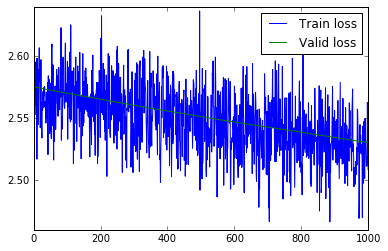

In [133]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

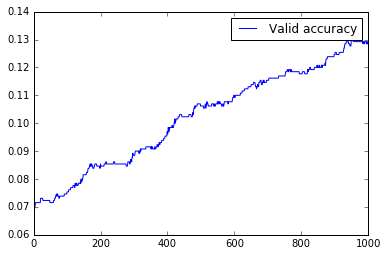

In [134]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()

In [59]:
# Test the final model
# y_pred, y_logit = nn.test(X_test)
# loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
# acc = np.mean(y_pred == y_test)
# print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
#     acc.mean(), acc.std(), loss))
# y_pred, y_logits = nn.test(X_test)
# mplot.imsave(y_pred)
# pd.DataFrame.to_csv(y_pred)
# y_pred.shape
# import numpy
# a = numpy.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
# numpy.savetxt("foo.csv", a, delimiter=",")
# np.savetxt(X=y_pred, delimiter=",", fname='y_predddddddddddddddddd.csv')

In [135]:
%ls

BCI-HW1/                                 foo.csv
BCI-HW2/                                 gradient_descent.py
bio-bp-dl/                               impl/
confusion_mat_cov.ipynb                  impl_imagernn_karpathy/
data/                                    LICENSE
DCNN.ipynb                               minimal_net.ipynb
Deep-FFNN-Tanh-FBA.ipynb                 misc/
Deep-FFNN-Tanh-FBA-ITD.ipynb             misc2/
Deep-FFNN-Tanh-FBA-ITD-Kaggle.ipynb      NOTES
Deep-FFNN-Tanh-FBA-Kaggle.ipynb          numba-cuda-gpu-example.ipynb
Deep-FFNN-Tanh-Vanilla.ipynb             output.csv
Deep-FFNN-Tanh-Vanilla-Kaggle.ipynb      README.md
DFFNN-FBA-STDP-Tanh-diff.ipynb           rnn-testing-platform/
DFFNN-FBA-STDP-Tanh-diff-no_FBA.ipynb    submission.csv
DFFNN-FBA-STDP-Tanh-TemporalDiff2.ipynb  tf-based/
DFFNN-FBA-STDP-Tanh-TemporalDiff.ipynb   y_predddddddddddddddddd2.csv
DFFNNs/                                  y_predddddddddddddddddd3.csv
DGRUs/                                   y_pr

In [136]:
train_y.head()

,Id,class_label
0,1,International
1,2,Vocal
2,3,Latin
3,4,Blues
4,5,Vocal


In [145]:
# for idx in range(y_pred.shape[0]): # y_txn
# # for idx in range(10): # y_txn
# # for each in y_pred[1000:1100]:
# #     print(val_to_key[y_pred[idx]])
#     labels.append((idx+1, val_to_key[y_pred[idx]]))
# #     labels.append([idx+1, val_to_key[y_pred[idx]]])
# #     labels.append(val_to_key[y_pred[idx]])

# len(labels), X_test.shape, labels[:10]

In [65]:
# pred_labels = np.array(labels)
# pred_labels.shape, pred_labels.dtype, pred_labels[:10]

In [66]:
# # import numpy as np
# # a = np.asarray([ [1,2,3], [4,5,6], [7,8,9] ])
# pred_labels.tofile('foo.csv',sep=',')

In [313]:
# # # Writing down the the prediction into the 'csv' file
# # np.savetxt(delimiter=',', fname='submission.csv', X=pred_labels) 
# # import csv

# # Finding the corresponding point to the time equivalent
# import csv
# RESULT = ['apple','cherry','orange','pineapple','strawberry']
# with open("output.csv",'wb') as resultFile:
#     wr = csv.writer(resultFile, dialect='excel')
#     wr.writerow(RESULT)

In [321]:
# Define Data
RESULTS = ['apple','cherry','orange','pineapple','strawberry']
# RESULTS  = []
# RESULTS.append(sample)
# Open File
resultFyle = open("output.csv",'w')

# Write data to file
for r in RESULTS:
#     resultFyle.write(r + "\n")
    resultFyle.write(r + ",")
resultFyle.close()

In [322]:
pd.read_csv(filepath_or_buffer='output.csv')

,apple,cherry,orange,pineapple,strawberry,Unnamed: 5


In [337]:
# Define Data
sample = ['apple','cherry','orange','pineapple','strawberry']
RESULTS  = []
for _ in range(5):
    RESULTS.append(sample)

# Open File
resultFyle = open("output.csv",'w')

# Write data to file
for sample in RESULTS:
    for r in sample:
# #     resultFyle.write(r + "\n")
        # Writing dow every row
#         resultFyle.write(r + ",")
        resultFyle.write(r)
        resultFyle.write(',')
#         resultFyle.write(r + "\n")
    # Move to the next line
#     resultFyle.
    resultFyle.write("\n")
resultFyle.close()

In [338]:
pd.read_csv(filepath_or_buffer='output.csv')

,apple,cherry,orange,pineapple,strawberry,Unnamed: 5
0,apple,cherry,orange,pineapple,strawberry,NaN
1,apple,cherry,orange,pineapple,strawberry,NaN
2,apple,cherry,orange,pineapple,strawberry,NaN
3,apple,cherry,orange,pineapple,strawberry,NaN


In [339]:
% ls

BCI-HW1/                                 foo.csv
BCI-HW2/                                 gradient_descent.py
bio-bp-dl/                               impl/
confusion_mat_cov.ipynb                  impl_imagernn_karpathy/
data/                                    LICENSE
DCNN.ipynb                               minimal_net.ipynb
Deep-FFNN-Tanh-FBA.ipynb                 misc/
Deep-FFNN-Tanh-FBA-ITD.ipynb             misc2/
Deep-FFNN-Tanh-FBA-ITD-Kaggle.ipynb      NOTES
Deep-FFNN-Tanh-FBA-Kaggle.ipynb          numba-cuda-gpu-example.ipynb
Deep-FFNN-Tanh-Vanilla.ipynb             output.csv
Deep-FFNN-Tanh-Vanilla-Kaggle.ipynb      README.md
DFFNN-FBA-STDP-Tanh-diff.ipynb           rnn-testing-platform/
DFFNN-FBA-STDP-Tanh-diff-no_FBA.ipynb    submission2.csv
DFFNN-FBA-STDP-Tanh-TemporalDiff2.ipynb  submission.csv
DFFNN-FBA-STDP-Tanh-TemporalDiff.ipynb   tf-based/
DFFNNs/                                  y_predddddddddddddddddd2.csv
DGRUs/                                   y_predddddddddddd

In [340]:
labels = []
# labels.append(('Id', 'class_label')) # Id starts with 1
labels.append('Id')
labels, labels_keys_sorted

(['Id'],
 ['Blues',
  'Country',
  'Electronic',
  'Folk',
  'International',
  'Jazz',
  'Latin',
  'New_Age',
  'Pop_Rock',
  'Rap',
  'Reggae',
  'RnB',
  'Vocal'])

In [341]:
test = labels_keys_sorted.copy()
# test.pop(), test.pop(), test.pop()
labels.append(labels_keys_sorted)
labels, test.insert(0, 'Id')
# title = np.array(test)
# print(*title), title, 
print(*test),
title = np.array(test)
title.shape
# sample_list = []
# sample_list.append([*test])
# # test.append('Id')
# print(*sample_list)
# sample_list2 = * sample_list
# np.array([*test]), np.array(test) 

Id Blues Country Electronic Folk International Jazz Latin New_Age Pop_Rock Rap Reggae RnB Vocal


(14,)

In [342]:
y_pred, y_logits = nn.test(X_test)
y_prob = l.softmax(y_logits)
y_prob.shape, X_test.shape, y_logits.shape, test_y_sample.shape, test_y_sample[:1]

((10400, 13),
 (10400, 26),
 (10400, 13),
 (10400, 14),
    Id   Blues  Country  Electronic    Folk  International    Jazz   Latin  \
 0   1  0.0964   0.0884      0.0121  0.1004         0.0137  0.1214  0.0883   
 
    New_Age  Pop_Rock     Rap  Reggae     RnB   Vocal  
 0   0.0765    0.0332  0.0445  0.1193  0.1019  0.1038  )

In [374]:
pred_list = []
# pred_list.append(test)
# pred_list
for Id, pred in enumerate(y_prob):
#     print(Id+1, *pred)
#     test.append(Id+1)
#     test.append(*pred)
    pred_list.append([Id+1, *pred])

    
# pred_arr = np.array(pred_list)
# # pred_arr.insert(*test, axis=0)
# submission = np.row_stack((title, pred_arr))
# submission.shape
# submission[:2]
# # pred_arr.shape
# print(pred_list[1])
# np.array(pred_list)
# new_list = []
# new_list.append(*pred_list[0])
# np.array(*pred_list[0])
# np.array(*pred_list)
# np.array(pred_list)
# np.array(pred_list)[0]
# y_prob[:10, :]

In [375]:
pred_file = open(file='prediction.csv', mode='w')

len(test), test[0]
# for key in test:
for idx in range(len(test)):
    if idx < len(test) - 1:
        pred_file.write(test[idx] + ',')
    else:
        pred_file.write(test[idx])        

# pred_file.write(-',')
pred_file.close()

In [376]:
pd.read_csv(filepath_or_buffer='prediction.csv')

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal


In [381]:
pred_list[0][0]

1

In [386]:
pred_file = open(file='prediction2.csv', mode='w')
pred_file.write('\n') # because of the previous line        

for idx in range(len(test)):
    if idx < len(test) - 1:
        pred_file.write(test[idx] + ',')
    else:
        pred_file.write(test[idx] + '\n')        

# len(test), test[0]
# for key in test:
for i in range(len(pred_list)): # rows
    for j in range(len(pred_list[i])): # cols
        if j < (len(pred_list[i]) - 1):
            pred_file.write(str(pred_list[i][j]))
            pred_file.write(',')
        else: # last item before starting a new line
            pred_file.write(str(pred_list[i][j]) + '\n')        

# pred_file.write(-',')
pred_file.close()

In [387]:
pd.read_csv(filepath_or_buffer='prediction2.csv')

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,1,0.063315,0.075692,0.090542,0.072905,0.076091,0.058305,0.072097,0.071053,0.052059,0.096331,0.074679,0.084148,0.112782
1,2,0.077229,0.072573,0.076020,0.070785,0.071869,0.067309,0.075531,0.071660,0.066383,0.090268,0.086847,0.079983,0.093543
2,3,0.086678,0.093590,0.083764,0.068918,0.085976,0.063847,0.068652,0.063477,0.075029,0.082691,0.072139,0.072459,0.082780
3,4,0.091982,0.071371,0.087378,0.063063,0.071639,0.072388,0.063234,0.060040,0.057063,0.094825,0.100601,0.085286,0.081129
4,5,0.065365,0.065053,0.102780,0.073557,0.069579,0.053834,0.062173,0.074761,0.049168,0.117644,0.073616,0.087466,0.105002
5,6,0.083222,0.054714,0.068426,0.102083,0.067446,0.076184,0.078843,0.076289,0.101379,0.072598,0.090601,0.056872,0.071342
6,7,0.078029,0.077064,0.090475,0.072782,0.068836,0.060585,0.071947,0.072302,0.066916,0.097056,0.087280,0.077138,0.079590
7,8,0.065526,0.089678,0.091900,0.080178,0.080373,0.058853,0.063003,0.074479,0.070979,0.109010,0.076619,0.070192,0.069210
8,9,0.061524,0.095653,0.083372,0.076891,0.060385,0.065853,0.061284,0.084767,0.069689,0.112807,0.093570,0.064286,0.069919
9,10,0.072775,0.090906,0.085638,0.058355,0.084724,0.064780,0.069944,0.071284,0.069426,0.108414,0.080399,0.068026,0.075328


In [388]:
test_y_sample
# test_y_sample

,Id,Blues,Country,Electronic,Folk,International,Jazz,Latin,New_Age,Pop_Rock,Rap,Reggae,RnB,Vocal
0,1,0.0964,0.0884,0.0121,0.1004,0.0137,0.1214,0.0883,0.0765,0.0332,0.0445,0.1193,0.1019,0.1038
1,2,0.0121,0.0804,0.0376,0.0289,0.1310,0.0684,0.1044,0.0118,0.1562,0.0585,0.1633,0.1400,0.0073
2,3,0.1291,0.0985,0.0691,0.0356,0.0788,0.0529,0.1185,0.1057,0.1041,0.0075,0.0481,0.1283,0.0238
3,4,0.0453,0.1234,0.0931,0.0126,0.1224,0.0627,0.0269,0.0764,0.0812,0.1337,0.0357,0.0937,0.0930
4,5,0.0600,0.0915,0.0667,0.0947,0.0509,0.0335,0.1251,0.0202,0.1012,0.0365,0.1310,0.0898,0.0991
5,6,0.0269,0.0928,0.1235,0.0598,0.1310,0.1400,0.1082,0.0676,0.0737,0.0690,0.0962,0.0093,0.0019
6,7,0.0890,0.0336,0.1151,0.0501,0.0919,0.1283,0.1361,0.0458,0.1260,0.0176,0.0305,0.0774,0.0585
7,8,0.1595,0.1299,0.0129,0.0179,0.0571,0.1243,0.0139,0.0447,0.0279,0.1086,0.1641,0.0026,0.1366
8,9,0.0490,0.1182,0.0968,0.0795,0.1007,0.0196,0.1387,0.0462,0.1452,0.0544,0.0756,0.0722,0.0040
9,10,0.0061,0.1402,0.0120,0.1327,0.1366,0.1036,0.0702,0.1167,0.0140,0.1400,0.0552,0.0399,0.0328


In [303]:
# y_prob.shape, y_prob.dtype, y_prob[:2]
# y_prob.tofile(file='submission.csv', sep=',', format='%5.5f')
submission.tofile(file='submission.csv', sep=',')

In [312]:
submission.tofile(file='submission2.csv', sep=',') #, format="%s"

In [304]:
%ls

BCI-HW1/                                 foo.csv
BCI-HW2/                                 gradient_descent.py
bio-bp-dl/                               impl/
confusion_mat_cov.ipynb                  impl_imagernn_karpathy/
data/                                    LICENSE
DCNN.ipynb                               minimal_net.ipynb
Deep-FFNN-Tanh-FBA.ipynb                 misc/
Deep-FFNN-Tanh-FBA-ITD.ipynb             misc2/
Deep-FFNN-Tanh-FBA-ITD-Kaggle.ipynb      NOTES
Deep-FFNN-Tanh-FBA-Kaggle.ipynb          numba-cuda-gpu-example.ipynb
Deep-FFNN-Tanh-Vanilla.ipynb             output.csv
Deep-FFNN-Tanh-Vanilla-Kaggle.ipynb      README.md
DFFNN-FBA-STDP-Tanh-diff.ipynb           rnn-testing-platform/
DFFNN-FBA-STDP-Tanh-diff-no_FBA.ipynb    submission.csv
DFFNN-FBA-STDP-Tanh-TemporalDiff2.ipynb  tf-based/
DFFNN-FBA-STDP-Tanh-TemporalDiff.ipynb   y_predddddddddddddddddd2.csv
DFFNNs/                                  y_predddddddddddddddddd3.csv
DGRUs/                                   y_pr

In [305]:
# sample =  np.fromfile('../Downloads/submission-random.csv', sep=',')

In [306]:
sample = pd.read_csv(filepath_or_buffer='submission.csv')

In [308]:
sample.head()

,'Id','Blues','Country','Electronic','Folk','International','Jazz','Latin','New_Age','Pop_Rock',...,'0.08492850423581863','0.08779660473153712','0.07962545437721189','0.08883812199891572','0.0631830150841213','0.06541243928632023','0.05838763749287561','0.070499351542608','0.08728107203218675','0.08786739375204171'


In [159]:
val_to_key[0], key_to_val['Blues']

('Pop_Rock', 5)

In [166]:
y_prob = pd.read_csv(filepath_or_buffer='y_prob.csv')

In [167]:
y_prob.head()

,0.00317,0.01518,0.46551,0.01597,0.00730,0.01441,0.07149,0.01446,0.32313,0.00510,...,0.01342.18,0.22801.1,0.14515.2,0.02259.11,0.05781.9,0.01140.21,0.16361.1,0.02778.14,0.02164.8,0.01738.18
